In [3]:
import specdb
import numpy as np
db_file = '/Users/Jenny/documents/pycodes/specdb/specdb/data/DB/IGMspec_DB_v03.hdf5'
from specdb.specdb import SpecDB
from matplotlib import pylab as plt
import numpy.ma as ma
from scipy import stats
from linetools.spectra.utils import smash_spectra
from linetools.spectra.xspectrum1d import XSpectrum1D
from random import choices
import itertools as it
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D

In [19]:
sdb = SpecDB(db_file=db_file)
sdb14 = sdb['BOSS_DR14']
meta_tbl = sdb['BOSS_DR14'].meta

times = 1000
#data = np.loadtxt("Lyman_alpha_result_deltatau_1.txt")
dr14index = np.loadtxt('/Users/Jenny/documents/pycodes/specdb/specdb/data/DB/BAL_selection_dr14_z>2.1_new.txt')
index = []
for i in range (len(dr14index)):
    index.append(int(dr14index[i]))
meta_tbl = meta_tbl[(meta_tbl['Z_PIPE'] > 2.1)
                    & (meta_tbl['Z_PIPE_ERR'] > 0.)
                    & (abs(meta_tbl['Z_VI'] - meta_tbl['Z_PIPE']) < 60 / 1216 * meta_tbl['Z_VI'])]
meta_tbl = meta_tbl[index]
print(len(meta_tbl))

#np.savetxt("test",[1,1], delimiter="  ", newline='\n')

def bootstrap_selection(zlow, zhigh, wavelow, wavehigh):
    '''
    function for generate mean xspectrum and all the bootstrap spectrum
    :param zlow: lower limit for redshift
    :param zhigh: upper limit for redshift
    :param wavelow: lower limit for wavelength range
    :param wavehigh: upper limit for wavelength range
    :return: bootstrap xspectrum: stacking, individal mean redhsift of bootstrap, mean flux, mena redshift
    '''

    #getting spectrum for each redshift bin from igmspec
    meta = meta_tbl[(meta_tbl['Z_PIPE'] > zlow)
                    & (meta_tbl['Z_PIPE_ERR'] > 0.)
                    & (meta_tbl['Z_PIPE'] < zhigh)
                    & (abs(meta_tbl['Z_VI'] - meta_tbl['Z_PIPE']) < 60 / 1216 * meta_tbl['Z_VI'])]
    print (len(meta))
    spec = sdb14.spec_from_meta(meta)


    wavelength = []

    flux = []

    length = []
    error = []

    z = []
    ave_stn = []
    #finding out the maximum length for each spectrum within certain wavelength range
    for i in range(0, len(meta['Z_PIPE'])):
        # print (spec[0].flux[mask1])
        mask2 = (np.array(spec[i].wavelength) < wavehigh * (1 + meta['Z_PIPE'][i])) & (
            np.array(spec[i].wavelength) > wavelow * (1 + meta['Z_PIPE'][i]))
        length.append(len(spec[i].wavelength[mask2]))
        mask_s_t_n = (np.array(spec[i].wavelength) < 1150 * (1 + meta['Z_PIPE'][i])) & (
            np.array(spec[i].wavelength) > 1075 * (1 + meta['Z_PIPE'][i]))
        # snr cut for snr >3
        signal = spec[i].flux[mask_s_t_n]
        s_t_n = signal / spec[i].sig[mask_s_t_n]
        ave_stn.append(np.median(s_t_n))
    print(np.max(length))

    #picking out the wavelength range we need
    for i in range(0, len(meta['Z_PIPE'])):
        mask3 = (np.array(spec[i].wavelength) < wavehigh * (1 + meta['Z_PIPE'][i])) & (
            np.array(spec[i].wavelength) > wavelow * (1 + meta['Z_PIPE'][i]))
        mask_mean = (np.array(spec[i].wavelength) < 1460 * (1 + meta['Z_PIPE'][i])) & (
            np.array(spec[i].wavelength) > 1440 * (1 + meta['Z_PIPE'][i]))

    #mask all the prominet skylines and generate the final flux, error, wavelength array for each spectrum within the redshift bin and wavelength range
        if (len(spec[i].wavelength[mask3] / (1 + meta['Z_PIPE'][i])) > (np.max(length) - 10)) & (ave_stn[i] > 2.2):
            # mean_error = np.sqrt(np.sum(np.array(spec[i].sig[mask1])) ** 2) / len(spec[i].flux[mask1])
            mask_mean_sky = (np.array(spec[i].wavelength) < 5590) & (np.array(spec[i].wavelength) > 5570)
            flux_error = spec[i].sig[mask3][:(np.max(length) - 11)]
            print(len(flux_error))
            mask4 = (np.array(spec[i].wavelength[mask3][:(np.max(length) - 11)]) < 5590) & (
            np.array(spec[i].wavelength[mask3][:(np.max(length) - 11)]) > 5570)
            mask5 = (np.array(spec[i].wavelength[mask3][:(np.max(length) - 11)]) < 4385) & (
            np.array(spec[i].wavelength[mask3][:(np.max(length) - 11)]) > 4340)
            spec[i].flux[mask_mean_sky] = np.zeros(len(spec[i].flux[mask_mean_sky]))
            mean = np.mean(spec[i].flux[mask_mean])
            flux_error[mask4] = np.zeros(len(flux_error[mask4]))
            flux_error[mask5] = np.zeros(len(flux_error[mask5]))
            if ((np.array(spec[i].flux[mask3][:(np.max(length) - 11)]) / (mean)) < - 8.0).any():
                flux_error = np.zeros(len(flux_error))
            error.append(flux_error)
            flux.append(np.array(spec[i].flux[mask3][:(np.max(length) - 11)]) / (mean))

            wavelength.append(spec[i].wavelength[mask3][:(np.max(length) - 11)] / (1 + meta['Z_PIPE'][i]))
            z.append(meta['Z_PIPE'][i])

    #generate the xspectrum
    stacking = []
    stacking_wave = np.mean(np.array(wavelength), axis=0)
    stacking_wave_final = np.repeat([stacking_wave], len(wavelength), axis = 0)
    #print(len(stacking_wave_final))
    wave = np.array(wavelength)
    sp = XSpectrum1D(np.array(stacking_wave_final), np.array(flux), np.array(error), verbose=False)
    totalindex = range(0, len(flux))
    redshift = []
    redshift_mean = np.mean(z)
    #genrate the final combine spectra for each redshift bin
    mean = smash_spectra(sp,'average')
    #generate the total bootstrap spectra (250) for 10000 times
    number = int(len(z))
    bootstrapindex = sorted(choices(totalindex, k=number) for i in range(times))
    for i in range(0, len(bootstrapindex)):
        spstack = sp[bootstrapindex[i]]
        stacking.append(smash_spectra(spstack,'average'))
        redshift.append(np.mean([z[x] for x in bootstrapindex[i]]))






    #plt.plot(stacking.wavelength, stacking.flux, label="z=3.9-4.0")
    #plt.xlabel('rest frame wavelength')
    #plt.ylabel('flux')
    #plt.legend()
    #plt.show()
    return stacking,redshift,mean,redshift_mean



def bootstrap_flux(zlow, deltaz, wmin, wmax):
    '''

    :param zlow:
    :param deltaz:
    :param wmin:
    :param wmax:
    :return: the covariance matrix for flux
    '''
    total_spec,redshift,mean,redshift_mean = bootstrap_selection(zlow, zlow + deltaz, wmin, wmax)
    flux_bootstrap = []
    for i in range(0, len(total_spec)):
        flux_bootstrap.append(total_spec[i].flux-mean.flux)
        
    
    

    flux_stack = np.vstack(np.transpose(flux_bootstrap))
    flux_bootstrap_final = np.dot(flux_stack, np.transpose(flux_stack)) / (times - 1)

    np.savetxt("covari_test_2.5_2.txt", flux_bootstrap, delimiter="  ", newline='\n')

    return  flux_stack,flux_bootstrap_final




Database is igmspec
Created on 2018-Mar-23
Version: v03
166473


In [20]:
plt.plot(bootstrap_flux(2.5,0.1,1075,1160)[0])

16374
Staged 16374 spectra totalling 1.22085 Gb
Loaded spectra

/Users/Jenny/Documents/pycodes/linetools/linetools/spectra/xspectrum1d.py:249: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")
/Users/Jenny/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/Jenny/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Jenny/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)



331
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320

320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320


320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320


320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320


320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320
320


In [22]:
datatest = np.loadtxt('covari_test_2.5_2.txt')

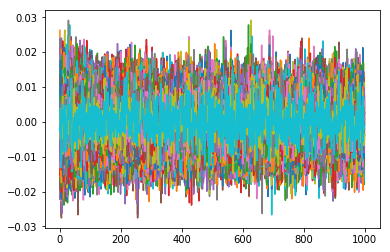

In [23]:
plt.plot(datatest)
plt.show()